In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./../../')
sys.path.append('./../../../')

from angular_spectrum.d2nn.d2nn import D2NN, DMD, SLM, CMOS
from angular_spectrum.sim.propagate_d2nn import propagate
from angular_spectrum.util.resolution_d2nn import zero_padding

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

def show_X(X, ratio=1):
    n = X.size(-1) // 2
    return X.detach().abs().square().squeeze().cpu().numpy()[
        int(n * (1 - ratio)): int(n * (1 + ratio)), 
        int(n * (1 - ratio)): int(n * (1 + ratio))
    ]

exp_idx = 0

grid_num = 500 # 
dmd_size = 8 * 500

grid_size = dmd_size / grid_num # um; total size: 1mm
load_resize = 0.4

dmd_pixel_size = None # grid_size * grid_num / size_of_image_in_pixel_num
slm_pixel_size = 8 # um

zs = [100 * 1000, 100 * 1000] # in um

wl = 0.5 # um, 500 nm visible light

# load dataset
class_num = 10 # handwritten digits

# prepare model
d2nn_base = D2NN(
    class_num, 
    grid_num, 
    grid_size, 
    int(dmd_size / slm_pixel_size), 
    zs, 
    frame_ratio=0.2, 
    load_resize=load_resize, 
    cmos_resize=load_resize,
    pad_ratio=1, 
) # cpu

d2nn_base.load_state_dict(torch.load(f'./../../saved_model/d2nn_base_{exp_idx}', map_location=torch.device('cpu')))


<All keys matched successfully>

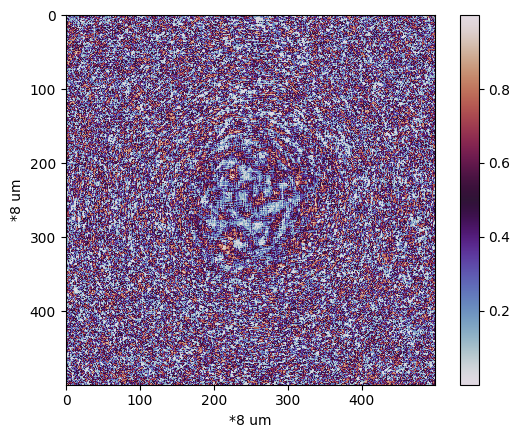

In [2]:
fig, ax = plt.subplots(1, 1)

s = ax.imshow(
    show_X(nn.functional.sigmoid(d2nn_base.slm_layers[0].tau / wl), 1), # note the definition of tau. see SLM
    cmap='twilight', 
    interpolation=None
)
ax.set_xlabel(f'*{slm_pixel_size} um')
ax.set_ylabel(f'*{slm_pixel_size} um')
fig.colorbar(s)

before d2nn 4400.0
after d2nn 4400.000000000004
y pred: tensor([15.5596, 22.7238,  7.6320,  7.2877,  7.1234,  2.6855,  8.3800,  8.2201,
        11.2976,  8.8585], dtype=torch.float64, grad_fn=<SumBackward1>)


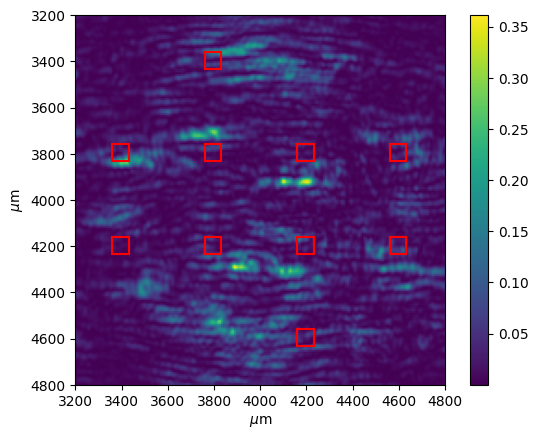

In [3]:
def before_cmos(model, X, wl, cmos=True):
    m = model
    X = zero_padding(m.dmd(X), m.pad_ratio + 1)
    # assert torch.count_nonzero((X.real != 0) & (X.real != 1)) == 0, 'bad binarization'

    print('before d2nn', X.abs().square().sum().item())
    if not cmos:
        return X
    X = propagate(X, m.grid_size, wl, m.zs[0])

    for i, (slm, z) in enumerate(zip(m.slm_layers, m.zs[1:])):
        X = slm(X, wl)
        X = propagate(X, m.grid_size, wl, z)
        continue

    print('after d2nn', X.abs().square().sum().item())
    return X    

d2nn_base.eval()

def change_resolution(d2nn, new_grid_num):
    d2nn.cmos.frame_s *= int(new_grid_num / d2nn.cmos.grid_num)
    d2nn.cmos.grid_num = d2nn.dmd.grid_num = d2nn.slm_layers[0].grid_num = new_grid_num
    d2nn.grid_size = dmd_size / new_grid_num


def draw_frame(ax, sq_idx, model, grid_size):
    classes = model.cmos.classes
    sq_idx = (
        sq_idx[1].reshape(classes, -1), sq_idx[0].reshape(classes, -1)
    )
    for c in range(classes):
        ymax, ymin = sq_idx[1][c].max() * grid_size, sq_idx[1][c].min() * grid_size
        xmax, xmin = sq_idx[0][c].max() * grid_size, sq_idx[0][c].min() * grid_size
        ax.plot([xmin, xmin], [ymin, ymax], color='red')
        ax.plot([xmax, xmax], [ymin, ymax], color='red')
        ax.plot([xmin, xmax], [ymin, ymin], color='red')
        ax.plot([xmin, xmax], [ymax, ymax], color='red')

def plot(X_test, cmos=True, y_label=None):

    # change_resolution(d2nn_base, 200)
    X_test = torch.tensor(X_test)
    d2nn_base.cpu()
    X_test_cpu = X_test.cpu()
    X = before_cmos(d2nn_base, X_test_cpu, wl, cmos=cmos)

    if cmos:
        y = d2nn_base(X_test_cpu, wl)
        print(f'y pred: {y}')
        if y_label is not None:
            print(f'y label: {y_label}')

    fig, ax = plt.subplots(1, 1)
    idx = d2nn_base.cmos.get_frame_idx(X)

    ratio = float(1 / (d2nn_base.pad_ratio + 1) * d2nn_base.dmd.resize_factor)

    s = ax.imshow(
        show_X(
            X, 
            ratio
        ), 
        extent=[
            grid_size * X.shape[0] * (1 - ratio) / 2,
            grid_size * X.shape[0] * (1 + ratio) / 2, 
            grid_size * X.shape[1] * (1 + ratio) / 2, 
            grid_size * X.shape[1] * (1 - ratio) / 2, 
        ],
        interpolation=None
    )
    if cmos:
        draw_frame(ax, idx, d2nn_base, grid_size)

    ax.set_xlabel(f'$\mu$m')
    ax.set_ylabel(f'$\mu$m')
    fig.colorbar(s)

    return X, y.argmax().item()


X = np.zeros((28, 28))
X[:, 12:15] = 1


X, y = plot(X, True)

In [14]:
torch.cuda.empty_cache()
eval_acc(X_test, y_test, wl, d2nn_base, 32)

100%|██████████| 313/313 [00:28<00:00, 10.80it/s]


tensor(0.9384, device='cuda:0')